In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv('../Resources/listing_clean_with_Postal_codes_errors_removed.csv')
df.head()

df_reduced = df[['Price','Beds','Baths','Postal_Code']]
df_reduced.head()

,Price,Beds,Baths,Postal_Code
0,430000,2,2,L5B 1N1
1,598000,2,1,M6H 3Z6
2,750000,4,2,L2R 5Y5
3,1899000,4,4,L8K 3P3
4,899000,4,2,L8V 3M7


In [3]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent='my_app')

geocode = lambda query: geolocator.geocode("%s, Ontario" % query)

In [4]:
import pgeocode
nomi = pgeocode.Nominatim('CA')


cities = []
lats = []
longs = []

for pc in df_reduced['Postal_Code']:
    cities.append(nomi.query_postal_code(pc).county_name)
    lats.append(nomi.query_postal_code(pc).latitude)
    longs.append(nomi.query_postal_code(pc).longitude)

    
df_reduced['City'] = cities
df_reduced['Latitude'] = lats
df_reduced['Longitude'] = longs

df_reduced.head()

/var/folders/9y/nv_s1mxx6p7bj2sk2_tl7sl80000gn/T/ipykernel_1319/1835919048.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reduced['City'] = cities
/var/folders/9y/nv_s1mxx6p7bj2sk2_tl7sl80000gn/T/ipykernel_1319/1835919048.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reduced['Latitude'] = lats
/var/folders/9y/nv_s1mxx6p7bj2sk2_tl7sl80000gn/T/ipykernel_1319/1835919048.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

,Price,Beds,Baths,Postal_Code,City,Latitude,Longitude
0,430000,2,2,L5B 1N1,Mississauga,43.5771,-79.6306
1,598000,2,1,M6H 3Z6,Toronto,43.6655,-79.4378
2,750000,4,2,L2R 5Y5,St. Catharines,43.1419,-79.2966
3,1899000,4,4,L8K 3P3,Hamilton,43.2211,-79.7994
4,899000,4,2,L8V 3M7,Hamilton,43.2266,-79.8499


In [5]:
df_reduced.head()

,Price,Beds,Baths,Postal_Code,City,Latitude,Longitude
0,430000,2,2,L5B 1N1,Mississauga,43.5771,-79.6306
1,598000,2,1,M6H 3Z6,Toronto,43.6655,-79.4378
2,750000,4,2,L2R 5Y5,St. Catharines,43.1419,-79.2966
3,1899000,4,4,L8K 3P3,Hamilton,43.2211,-79.7994
4,899000,4,2,L8V 3M7,Hamilton,43.2266,-79.8499


In [6]:
df_reduced.count()

Price          3252
Beds           3252
Baths          3252
Postal_Code    3252
City           2404
Latitude       3107
Longitude      3107
dtype: int64

In [7]:
dropped_df = df_reduced.dropna()

dropped_df.count()

Price          2404
Beds           2404
Baths          2404
Postal_Code    2404
City           2404
Latitude       2404
Longitude      2404
dtype: int64

In [8]:
features = dropped_df[['Beds','Baths','City']]

In [9]:
X = features.copy()
X['City'] = LabelEncoder().fit_transform(X['City'])
X.tail()

,Beds,Baths,City
3244,2,2,44
3245,2,1,50
3248,6,3,33
3250,4,2,41
3251,7,4,41


In [10]:
X.count()

Beds     2404
Baths    2404
City     2404
dtype: int64

In [11]:
y = dropped_df['Price']

In [12]:
# Scale the dataset using MinMaxScaler()
X_scaled = MinMaxScaler().fit_transform(X)
X_scaled

array([[0.05882353, 0.07692308, 0.46551724],
       [0.05882353, 0.        , 0.86206897],
       [0.17647059, 0.07692308, 0.77586207],
       ...,
       [0.29411765, 0.15384615, 0.56896552],
       [0.17647059, 0.07692308, 0.70689655],
       [0.35294118, 0.23076923, 0.70689655]])

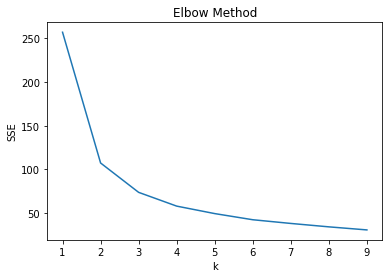

In [13]:
sse = {}
K = range(1, 10)
for k in K:
    kmeanmodel = KMeans(n_clusters=k).fit(X_scaled)
    sse[k]= kmeanmodel.inertia_
    
# Plot
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.show()

In [14]:
# Create a KMeans model with 3 clusters
model = KMeans(n_clusters=4, random_state=42).fit(X_scaled)

In [15]:
# Calculate predicted values.
y_pred = model.predict(X_scaled)

In [16]:
# Add predicted values onto the original dataframe
df_y = pd.DataFrame(y_pred, columns=['Cluster'])
combined = dropped_df.join(df_y, how='inner')
combined.head()

,Price,Beds,Baths,Postal_Code,City,Latitude,Longitude,Cluster
0,430000,2,2,L5B 1N1,Mississauga,43.5771,-79.6306,1
1,598000,2,1,M6H 3Z6,Toronto,43.6655,-79.4378,2
2,750000,4,2,L2R 5Y5,St. Catharines,43.1419,-79.2966,2
3,1899000,4,4,L8K 3P3,Hamilton,43.2211,-79.7994,1
4,899000,4,2,L8V 3M7,Hamilton,43.2266,-79.8499,1


<AxesSubplot:title={'center':'Price'}, xlabel='[Cluster]'>

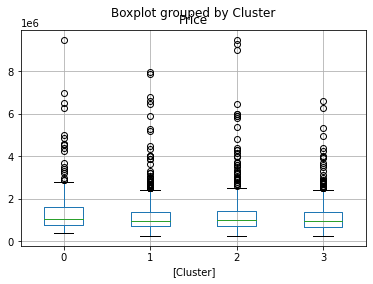

In [17]:
# Plot boxplots of the Price distributions by Cluster
combined.boxplot(['Price'], by=['Cluster'])

<AxesSubplot:xlabel='City'>

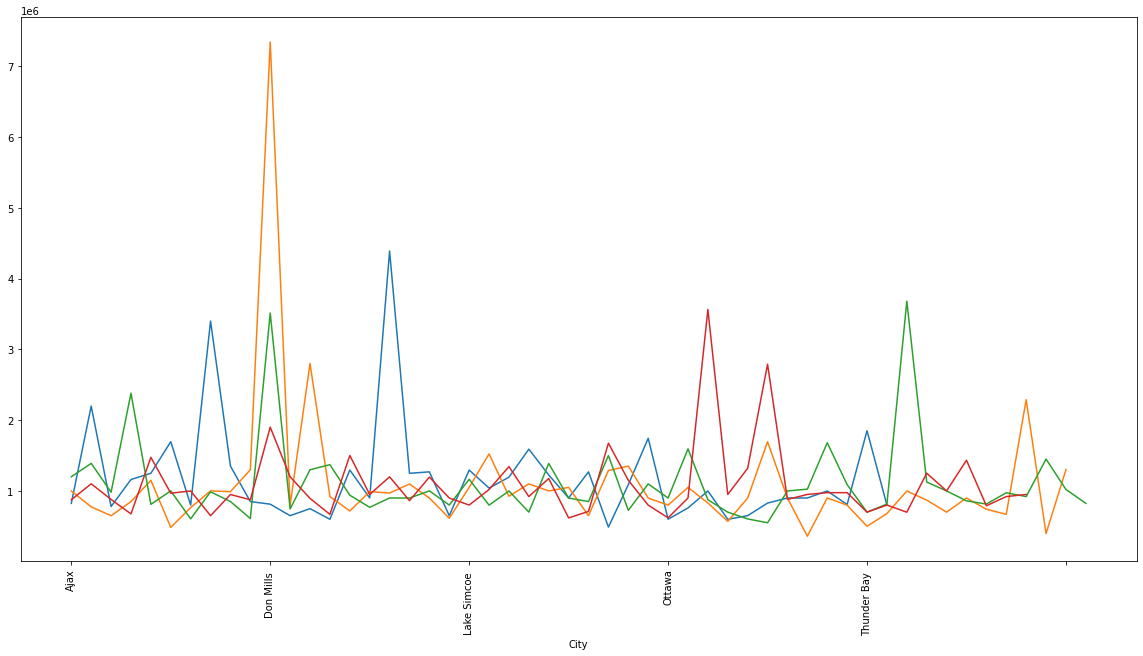

In [18]:
# Plot median price times by city for each cluster

combined[combined['Cluster'] == 0].groupby('City').median()['Price'].plot(rot=90, figsize=(20,10))
combined[combined['Cluster'] == 1].groupby('City').median()['Price'].plot(rot=90, figsize=(20,10))
combined[combined['Cluster'] == 2].groupby('City').median()['Price'].plot(rot=90, figsize=(20,10))
combined[combined['Cluster'] == 3].groupby('City').median()['Price'].plot(rot=90, figsize=(20,10))

In [20]:
combined.to_csv("../Resources/clustered_listings.csv")